In [1]:
## Import the necessary packages
import os
import torch

from bs4 import BeautifulSoup

from PIL import Image

import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor



import matplotlib.pyplot as plt
import matplotlib.patches as patches


## Setup to run on GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

c:\Python310\lib\site-packages\torchvision\models\detection\anchor_utils.py:63: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf . Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem . (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:84.)
  device: torch.device = torch.device("cpu"),


ModuleNotFoundError: No module named 'matplotlib'

1. Preparing and Loading Data

We make some functions to help unpack the data so that we can a) input it into Pytorch and b) can easily assign labels to the data.

In [ ]:
## Reorder the variables since coco format encodes bounding box as [x_min, y_min, width, height]
## Pytorch wants [x_min, y_min, x_max, y_max]
def make_box(obj):
  x_min = int(obj.find('xmin').text)
  x_max = int(obj.find('xmax').text)
  y_min = int(obj.find('ymin').text)
  y_max = int(obj.find('ymax').text)

  return [x_min, y_min, x_max, y_max]

## Assign labels for each class. 
## 0 - Correctly worn mask
## 1 - Incorrectly worn mask
## 2 - No mask

def make_label(obj):
  if obj.find('name').text == 'with_mask':
    return 1
  elif obj.find('name').text == 'mask_weared_incorrect':
    return 2
  else:
    return 3

def make_target(id, file):
  with open(file) as f:
    data = f.read()
    soup = BeautifulSoup(data, 'xml')
    objects = soup.find_all('object')

    bboxes = []
    labels = []
    for i in objects:
      bboxes.append(make_box(i))
      labels.append(make_label(i))
    
    ## Convert bboxes and labels to tensors
    bboxes = torch.as_tensor(bboxes, dtype = torch.float32)
    labels = torch.as_tensor(labels, dtype = torch.int64)

    img_id = torch.tensor([id])

    target = {}
    target['boxes'] = bboxes
    target['labels'] = labels
    target['image_id'] = img_id

    return target

Now that we have the above functions, we will import the images

In [ ]:
img_dir = 'C:/Users/samri/ML Projects/FacemaskProject/images/'
label_dir = 'C:/Users/samri/ML Projects/FacemaskProject/annotations/'

class Data_creation(object):
  def __init__(self, transforms):
    self.transforms = transforms
    self.imgs = list(sorted(os.listdir(img_dir)))
    self.labels = list(sorted(os.listdir(label_dir)))

  def __getitem__(self, idx):
    file_image = 'maksssksksss'+ str(idx) + '.png'
    file_label = 'maksssksksss'+ str(idx) + '.xml'

    img_path = os.path.join(img_dir, file_image)
    label_path = os.path.join(label_dir, file_label)

    img = Image.open(img_path).convert('RGB')
    target = make_target(idx, label_path)

    if self.transforms is not None:
      img = self.transforms(img)

    return img, target
  def __len__(self):
    return len(self.imgs)

data_transform = transforms.Compose([
    ToTensor()                                     
  ])

def collate_fn(batch):
  return tuple(zip(*batch))

data = Data_creation(data_transform)

train_percent = .8
train_size = int(len(data)*train_percent)
test_size = len(data)-train_size

trainset,testset=torch.utils.data.random_split(data,[train_size,test_size])

#data_loader = torch.utils.data.DataLoader(
#    data, batch_size = 4, collate_fn = collate_fn
#)

train_dataloader = torch.utils.data.DataLoader(dataset=trainset,
                                               batch_size=32,shuffle=True, collate_fn = collate_fn)
test_dataloader = torch.utils.data.DataLoader(dataset=testset,
                                              batch_size=32,shuffle=False, collate_fn = collate_fn)



We can also look at some of the images to get a better understanding of what we are working with.

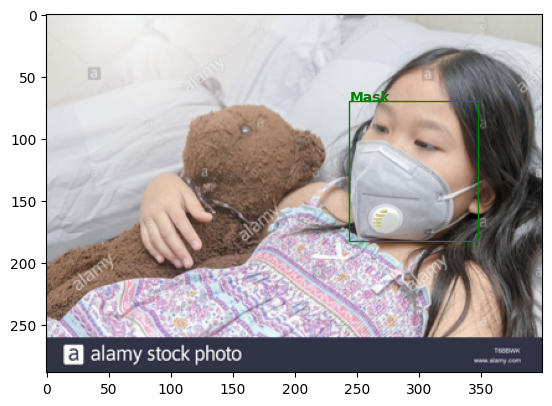

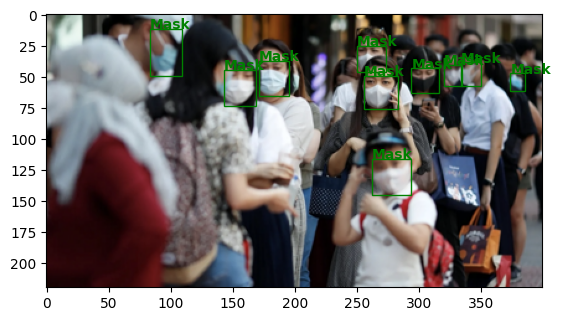

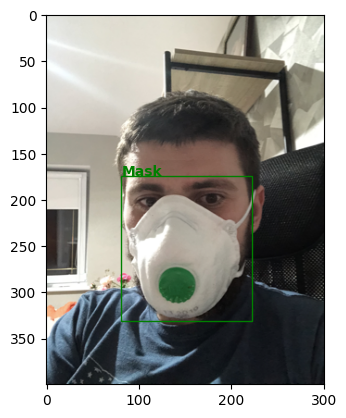

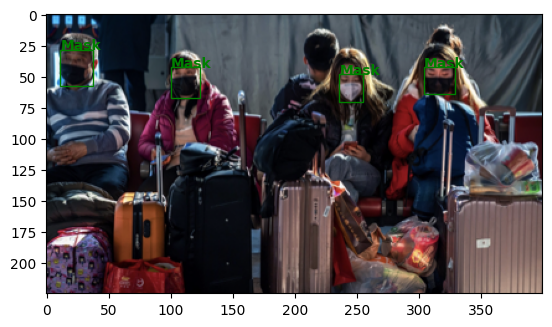

In [ ]:
for imgs, annotations in train_dataloader:
  imgs = list(img.to(device) for img in imgs)
  annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
  break


def plot_img(img_tens, annotation):
  fig, ax = plt.subplots(1)

  ## Must send data to CPU for plotting
  img = img_tens.cpu().data

  ax.imshow(img.permute(1,2,0))

  ## Detaching so that we can plot predictions later
  for box, label in zip(annotation['boxes'].cpu().detach(), annotation['labels'].cpu().detach()):
    xmin, ymin, xmax, ymax = box

    if label == 1:
      rect = patches.Rectangle((xmin, ymin),(xmax-xmin),(ymax-ymin),linewidth = 1,
                              edgecolor = 'g', facecolor = 'none')
      x, y = rect.get_xy()
      ax.annotate('Mask', (x, y), color='g', weight='bold', fontsize=10, ha='left', va='baseline')
    elif label == 2:
      rect = patches.Rectangle((xmin, ymin),(xmax-xmin),(ymax-ymin),linewidth = 1,
                              edgecolor = 'y', facecolor = 'none')
      x, y = rect.get_xy()
      ax.annotate('Incorrectly worn', (x, y), color='y', weight='bold', fontsize=10, ha='left', va='baseline')
    elif label == 3:
      rect = patches.Rectangle((xmin, ymin),(xmax-xmin),(ymax-ymin),linewidth = 1,
                              edgecolor = 'r', facecolor = 'none')
      x, y = rect.get_xy()
      ax.annotate('No mask', (x, y), color='r', weight='bold', fontsize=10, ha='left', va='baseline')


    ax.add_patch(rect)

  plt.show()

for i in range(4):
  plot_img(imgs[i], annotations[i])

2. FasterRCNN Model

We will import a pre-trained segmentation model that was trained on COCO.


In [ ]:
def import_pretrained_model(num_classes):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes+1)

  return model

model1 = import_pretrained_model(3)

c:\Users\samri\ML Projects\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\samri\ML Projects\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The pre-trained model has been imported, so we will train the model now.

In [ ]:
num_epochs = 25
model1.to(device)

params = [p for p in model1.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=.001, momentum = .9, weight_decay = .0005)

for epoch in range(num_epochs):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    epoch_loss = 0
    for imgs, annotations in train_dataloader:
        model1.train() 

        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

        loss_dict = model1([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    print(f'Loss for Epoch {epoch+1} is: {epoch_loss}\n')

Epoch: 0
-------


KeyboardInterrupt: 

Now, we can check to see how the model performs.

In [ ]:
model1.eval()

score_sum = 0
num_pred = 0

with torch.inference_mode():
    for imgs, annotations in test_dataloader:
        imgs = list(img.to(device) for img in imgs)
        outputs = model1(imgs)

        score_sum += sum(outputs[0]['scores'])
        num_pred += len(outputs[0]['scores'])

avg_score = score_sum/num_pred
print(f'The average score for our predictions is {avg_score}')


The average score for our predictions is 0.2830227315425873


In [ ]:
torch.save(model1.state_dict(),'C:/Users/samri/ML Projects/FacemaskProject/model.pt')

Now that the model has be trained and saved. We can visualize some of the predictions. Will will only be looking at predictions whose score is greater than .8.

Prediction


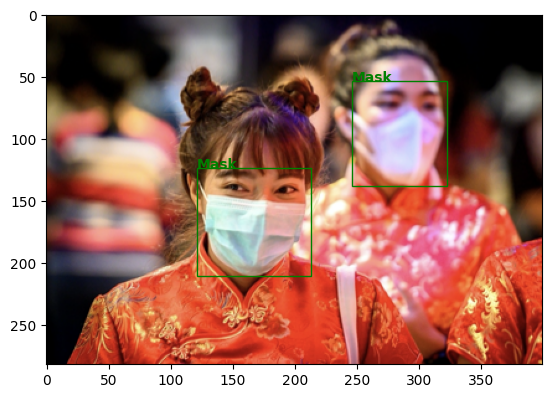

Actual


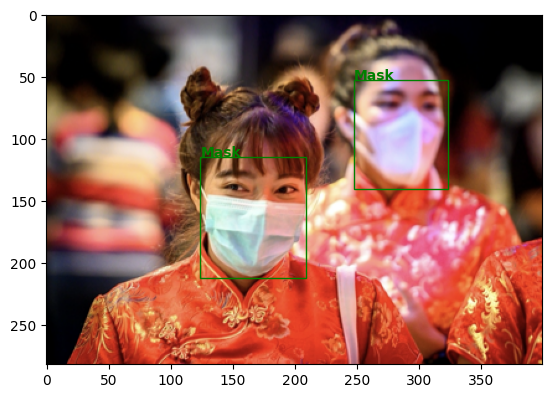

Prediction


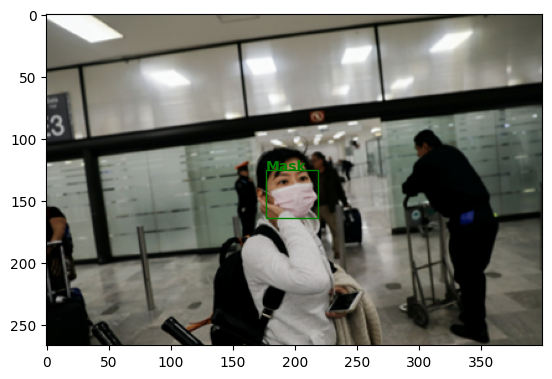

Actual


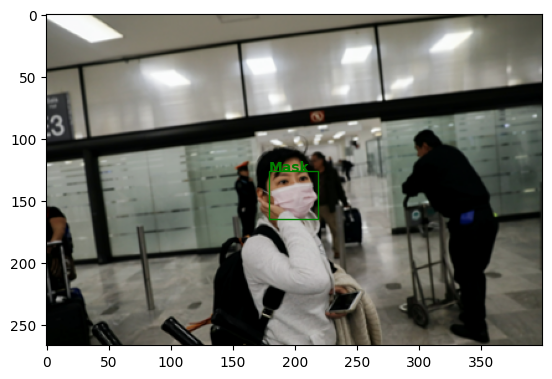

Prediction


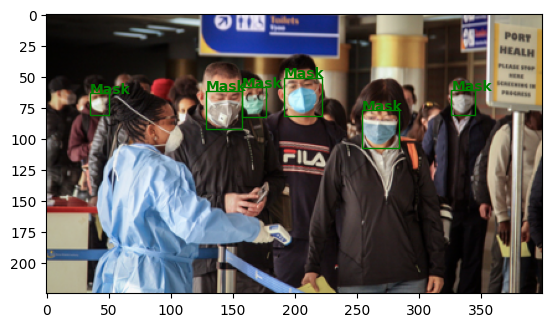

Actual


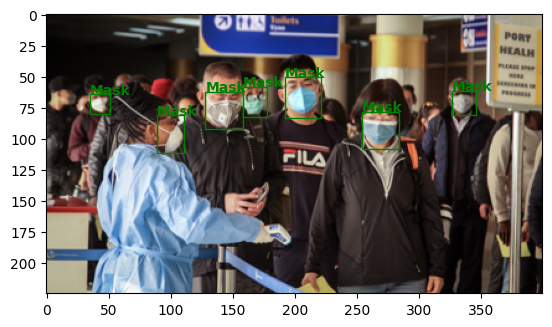

In [ ]:
## This is effectively the same as plot_img except now there is a cutoff parameter which gives a score threshold for plotting. 
def plot_pred(img_tens, prediction, cutoff = 0.8):
  fig, ax = plt.subplots(1)

  ## Must send data to CPU for plotting
  img = img_tens.cpu().data

  ax.imshow(img.permute(1,2,0))

  for box, label, score in zip(prediction['boxes'].cpu().detach(), prediction['labels'].cpu().detach(), prediction['scores'].cpu().detach()):
    if score < cutoff:
      continue

    xmin, ymin, xmax, ymax = box

    if label == 1:
      rect = patches.Rectangle((xmin, ymin),(xmax-xmin),(ymax-ymin),linewidth = 1,
                              edgecolor = 'g', facecolor = 'none')
      x, y = rect.get_xy()
      ax.annotate('Mask', (x, y), color='g', weight='bold', fontsize=10, ha='left', va='baseline')
    elif label == 2:
      rect = patches.Rectangle((xmin, ymin),(xmax-xmin),(ymax-ymin),linewidth = 1,
                              edgecolor = 'y', facecolor = 'none')
      x, y = rect.get_xy()
      ax.annotate('Incorrectly worn', (x, y), color='y', weight='bold', fontsize=10, ha='left', va='baseline')
    elif label == 3:
      rect = patches.Rectangle((xmin, ymin),(xmax-xmin),(ymax-ymin),linewidth = 1,
                              edgecolor = 'r', facecolor = 'none')
      x, y = rect.get_xy()
      ax.annotate('No mask', (x, y), color='r', weight='bold', fontsize=10, ha='left', va='baseline')


    ax.add_patch(rect)

  plt.show()

for i in range(3):
  print('Prediction')
  plot_pred(imgs[i],outputs[i])
  print('Actual')
  plot_img(imgs[i],annotations[i])

We can see that our model does a pretty good job!